# TMLE - Targeted Maximum Likelihood Estimation

Targeted learning is a method developed by Mark van der Laan [[1](https://www.degruyter.com/document/doi/10.2202/1557-4679.1043/html     )] establishing a theoretically-guaranteed way of applying complex machine learning estimators to causal inference estimation.  

### Motivation
Let's denote $X$ as our confounding features, $Y$ our target variable and $A$ a binary intervention variable whose effect we seek.  
Recall that a regular outcome model (i.e., a Standrdization model like S-Learner), simply works by estimating $E[Y|X,A]$. 
However, the way it adjusts for $X$ and $A$ dependends on the core-statitsical estimator used. 
For example, a strictly linear (i.e. no interactions or polynomials) regression model will adjust for $X$ linearly, but that might not describe the response suface properly, especially in high-dimensional complex data.
To account for more complex data, we can use a more complex core estimator.  
However, applying expressive estimators might lead to some bias in estimating the causal effect of the treatment.
In most real-world scenarios, the treatment effect is usually pretty small, and not unrelatedly, it might have very little predictive power over the outcome. 
For example, imagine feeding a tree-based estimator a matrix with features stacked with a treatment assignment column (like an S-learner). 
It is not unreasonable that the tree might simply ignore the treatment variable altogether. 
And so, it will conclude a strictly zero causal effect estimation, since there's no difference in outcome when we plug in $A=1$ and $A=0$.  
This happens because we optimize the prediction $E[Y|X,A]$, which is not the same as optimizing for the causal parameter of interest $E[Y|X,A=1]-E[Y|X,A=0]$.  

### Intutition
A naive statistical estimator will maximize the global likelihood - it will try to estimate correctly _all_ the coefficients of all covariates, only one of which is the treatment assignment.
However, we care for one single parameter - the treatment effect - more than we care for other parameters.
Therefore, we would like to focus our estimator's attention on that parameter of interest, even at the price of neglecting some other parameters.  
Using Dr. Susan Gruber's example, think of it like a picture - where the person smiling is of greater importance, so in order to focus on them we allow the background to become a bit more blurry in exchange.  

While the math behind it is complex, the basic principle is pretty simple: 
In order to focus our estimator on the treatment effect, we will use information from the treatment mechanism to update and re-target the initial outcome model prediction.
This will allow us to use highly data-adaptive preidction models, but still estimate the treatment effect properly.


### Steps
Fitting a TMLE can be summarized into four simple steps:
1. Fit an outcome model $Q_0(A,X)$, estimating $E[Y|X,A]$ by predicting the outcome $Y$ using the covariates $X$ and the treatment $A$.  
   $Q_0$ can be a highly expressive method, and a common use is a "Super Learner", which is basically a stacking meta-learner using a broad library (pool) of base-estimators.  
   In causallib, this will be done by specifying a `Standardization` model with any kind of core estimator.
1. Fit a propensity model $g(A,X)$, estimating $\Pr[A|X]$ by predicting the treatment assignment $A$ using the covariate $X$.  
   In `causallib`, this will be done by specifying an `IPW` model with any kind of core estimator.  
   Note that `causallib` also allows this set of `X` to be different than the `X` used for the outcome model in step 1.
1. Generate a "clever covariate"* $H(A,X)$ using the propensity scores: $\frac{2A-1}{g(A,X)}$.
   Namely: take the inverse propensity scores of the treated units, and the _minus_ inverse propensities for the controls.
1. Update the initial outcome prediction using treatment information from the "clever covariate": estimate an $\epsilon$ parameter such that:  
   $ Q_*(A,X) = expit(logit(Q_0(A,X))+ \epsilon H(A,X))$  
   Namely, we update the initial $Q_0$ with some contribution of $H(A,X)$ estimated in logit space.  
   in causallib, this is estimated by applying a uni-variable logistic regression, regressing $Y$ on $H(A,X)$ with $Q_0(A,X)$ as offset (i.e. forcing its coefficient to 1).  
   
The intuition behind step (4) is that we basically regressing the "clever covariate" (with its treatment mechanism information) on the residuals of the outcome prediction. 
If the initial prediction is perfect - then $H(A,X)$ is regressed on random noise and $\epsilon$ is therefore $\approx 0$, contributing nothing to the update step.
However, in case there _is_ residual bias in the initial estimator, $\epsilon$ will control the magnitude of correction needed - small residual bias will lead to small update and vice versa. 
This is because "surprising" units, those with small $g(A,X)$, have large $\frac{1}{g(A,X)}$, so small changes in $\epsilon$ will lead to bigger impact on the fitting.  
This is also why we need to be extra careful avoiding overfitting the initial estimator $Q_0$, because it will falsely minimize the signal in the residuals required for the updating step. 

Note that there are several flavors of the "clever covariates", which causallib implements 4 of, and they will be described further down. 

#### Counterfactual prediction
For counterfactual prediction we assign a specific treatment value $a\in A$ and propagate it through the model's component:  
$ Q_*(a,X) = expit(logit(Q_0(a,X))+ \epsilon H(a,X))$    
And then we can calculate any contrast of two intevention values to obtain an effect, like risk difference ($Q_*(1,X)-Q_*(0,X)$) or risk ratio ($\frac{Q_*(1,X)}{Q_*(0,X)}$).


### Doubly robust
TMLE combines an outcome model with a treatment model in a way that makes it doubly robust: we get two chances to get things right.  
As we seen above, We either correctly specify the outcome model and then there's no signal left for correction by the treatment model.
And, conversly, in cases were the initial model is strongly misspecified (think a simple `Y~A` regression), then $\epsilon$ will be large and cover up for it like an IPW model.
Therefore, the targeting step is a second chance to get things right.

### Conclusion
TMLE for causal framework allow us to apply flexible machine learning estimators on high-dimensional complex data and still obtain valid causal effect estimations.


## TMLE in `causallib`

Let's see an example of how TMLE works using `causallib`

In [1]:
import pandas as pd
import numpy as np

from causallib.estimation import TMLE
from causallib.estimation import Standardization, IPW
from mlxtend.classifier import StackingCVClassifier
from mlxtend.regressor import StackingCVRegressor

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier, RandomForestClassifier
# from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Lasso, Ridge, LinearRegression, LassoCV, RidgeCV

import matplotlib.pyplot as plt
import seaborn as sns

### Data
We synthesize data, so we know the true causal effect, based on [_Schuler and Rose 2017_](https://academic.oup.com/aje/article/185/1/65/2662306).  
This is a relatively simple mechanism where exposure is dependent on a linear combination of 3 Bernoulli variables and the outcome also depends on an effect modification of the third variable.

In [2]:
df = pd.read_csv("bpi2017_final.csv")
print(df.columns)
df.head()

Index(['case:concept:name', 'NumberOfOffers', 'Action', 'org:resource',
       'concept:name', 'EventOrigin', 'lifecycle:transition', 'time:timestamp',
       'case:LoanGoal', 'case:ApplicationType', 'case:RequestedAmount',
       'FirstWithdrawalAmount', 'NumberOfTerms', 'Accepted', 'MonthlyCost',
       'Selected', 'CreditScore', 'OfferedAmount', 'treatedCase',
       'caseSuccesful', 'treatmentSuccess', 'offerNumber', 'offerSuccess',
       'treatmentOffer', 'timeApplication', 'weekdayApplication'],
      dtype='object')


,case:concept:name,NumberOfOffers,Action,org:resource,concept:name,EventOrigin,lifecycle:transition,time:timestamp,case:LoanGoal,case:ApplicationType,...,CreditScore,OfferedAmount,treatedCase,caseSuccesful,treatmentSuccess,offerNumber,offerSuccess,treatmentOffer,timeApplication,weekdayApplication
0,0.0,1.0,0.0,0.0,4.0,0.0,1.0,651433.0,10.0,1.0,...,0.0,5000.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000,2.0
1,0.0,1.0,4.0,0.0,8.0,0.0,1.0,651434.0,10.0,1.0,...,0.0,5000.0,0.0,0.0,0.0,1.0,0.0,0.0,0.061,2.0
2,0.0,1.0,0.0,0.0,22.0,2.0,3.0,651435.0,10.0,1.0,...,0.0,5000.0,0.0,0.0,0.0,1.0,0.0,0.0,0.290,2.0
3,0.0,1.0,1.0,0.0,22.0,2.0,6.0,651437.0,10.0,1.0,...,0.0,5000.0,0.0,0.0,0.0,1.0,0.0,0.0,66.613,2.0
4,0.0,1.0,0.0,0.0,21.0,2.0,3.0,651438.0,10.0,1.0,...,0.0,5000.0,0.0,0.0,0.0,1.0,0.0,0.0,66.620,2.0


In [3]:
feature_names = ['NumberOfOffers', 'Action', 'org:resource',
       'concept:name', 'EventOrigin', 'lifecycle:transition', 'time:timestamp',
       'case:LoanGoal', 'case:ApplicationType', 'case:RequestedAmount',
       'FirstWithdrawalAmount', 'NumberOfTerms', 'Accepted', 'MonthlyCost',
       'CreditScore', 'OfferedAmount', 'offerNumber','timeApplication', 'weekdayApplication']

In [4]:
#Y = Outcome
#a = treatment
#X = features
def run_single_simulation(tmle, n_samples, seed=None):
    a=df['treatmentOffer']
    X = df[feature_names]
    y=df['offerSuccess']
    tmle.fit(X, a, y)
    sate = 0
    
    tmle_po = tmle.estimate_population_outcome(X, a)
    tmle_ate = tmle.estimate_effect(tmle_po[1], tmle_po[0])['diff']
    
    outcome_model_po = tmle.outcome_model.estimate_population_outcome(X, a)
    outcome_model_ate = tmle.outcome_model.estimate_effect(outcome_model_po[1], outcome_model_po[0])['diff']
    
    return tmle_ate, outcome_model_ate, sate


def run_multiple_simulations(tmle, n_simulations, n_samples):
    true_ates = []
    tmle_ates = []
    om_ates = []
    for i in range(n_simulations):
        tmle_ate, outcome_model_ate, sate = run_single_simulation(tmle, n_samples, i)

        tmle_ates.append(tmle_ate)
        om_ates.append(outcome_model_ate)
        true_ates.append(sate)
    
    predictions = pd.DataFrame(
        {"tmle": tmle_ates, "initial_model": om_ates, "true": true_ates}
    ).rename_axis("simulation").reset_index()
    # true_ate = np.mean(true_ates)
    true_ate = 0
    return predictions, true_ate

def plot_multiple_simulations(results, true_ate):
    results = results.drop(columns=["true"])
    results = results.melt(id_vars="simulation", var_name="method", value_name="ate")
    
    # Plot inidividual experiments:
    fig, axes = plt.subplots(1, 2, sharey=True,  
                             gridspec_kw={'width_ratios': [3, 1]},
                             figsize=(8, 3))
    sns.scatterplot(
        x="simulation", y="ate", hue="method", style="method", 
        data=results, 
        ax=axes[0]
    )
    axes[0].axhline(y=true_ate, linestyle='--', color="grey")
    # axes[0].text(results["simulation"].max(), true_ate - 0.1, "True ATE", color="slategrey")
    # (results.set_index(["simulation", "method"]) - true_ate).groupby("method").mean()
    
    # Plot distribution summary:
    axes[1].axhline(y=true_ate, linestyle='--', color="grey")
    sns.kdeplot(
        y="ate", hue="method", 
        data=results,
        legend=False,
        ax=axes[1]
    )
    axes[1].text(axes[1].get_xlim()[1], true_ate - 0.2, "True ATE", color="slategrey")
    
    # mean_bias = (results.set_index(["simulation", "method"]) - true_ate).groupby("method").mean()
    # pd.plotting.table(axes[2], mean_bias)
    
    axes[0].legend(loc='center left', bbox_to_anchor=(1.35, 0.1))

    plt.subplots_adjust(wspace=0.01)
    return axes
    

### Doubly Robustness

We will see how misspecifying either outcome model is contradicted by TMLE and results in an overall good estimation

We start by specifying the outcome model to be an L1-regularized logistic regression (LASSO). The model is also misspecified as it doesn't take into account the interactions between the treatment and the third indicator.

In [6]:
outcome_model = Standardization(Lasso(random_state=0))
weight_model = IPW(LogisticRegression(penalty="none", random_state=0))
tmle = TMLE(
    outcome_model=outcome_model,
    weight_model=weight_model,
    reduced=True
)

n_samples = 1
n_simulations = 1

results, true_ate = run_multiple_simulations(tmle, n_simulations, n_samples)
#plot_multiple_simulations(results, true_ate);

/pfs/data5/home/ma/ma_ma/ma_mskiera/causallib/lib64/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/pfs/data5/home/ma/ma_ma/ma_mskiera/causallib/lib64/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/pfs/data5/home/ma/ma_ma/ma_mskiera/causallib/lib64/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/pfs/data5/home/ma/ma_ma/ma_mskiera/causallib/lib64/python3.9/site-packages/sklearn/utils/validation.py:1858: F

ValueError: Image size of 879x72133 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 800x300 with 2 Axes>

In [7]:
results

,simulation,tmle,initial_model,true
0,0,-0.000583,0.0,0
1,1,-0.000583,0.0,0
2,2,-0.000583,0.0,0


We see that the outcome model predictions are way off toards the null, probably even ignoring the treatment column occasionally (where effect is near 0).

We can improve that by first allowing a more flexible model (by using interactions), and also using cross-validation to find the right amount of regularization over all the new polynomial parameters.

In [9]:
outcome_model_standard = Standardization(make_pipeline(PolynomialFeatures(2), LassoCV(random_state=0)))
tmle_standard = TMLE(
    outcome_model=outcome_model_standard,
    weight_model=weight_model,
    reduced=True
)

n_samples = 500
n_simulations = 2

results_standard, true_ate = run_multiple_simulations(tmle_standard, n_simulations, n_samples)
print(results_standard)

/pfs/data5/home/ma/ma_ma/ma_mskiera/causallib/lib64/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/pfs/data5/home/ma/ma_ma/ma_mskiera/causallib/lib64/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/pfs/data5/home/ma/ma_ma/ma_mskiera/causallib/lib64/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/pfs/data5/home/ma/ma_ma/ma_mskiera/causallib/lib64/python3.9/site-packages/sklearn/utils/validation.py:757: Fu

   simulation      tmle  initial_model  true
0           0 -0.000868            0.0     0
1           1 -0.000868            0.0     0


This is much better performance by the initial outcome model. Though we can see TMLE is able to slightly correct it.

Finally, that we have a well-specified outcome model, we can extermly limit our weight model so it is misspecfied and see what happens:

In [6]:
outcome_model_standard = Standardization(make_pipeline(PolynomialFeatures(2), LassoCV(random_state=0)))
weight_model_ipw = IPW(make_pipeline(PolynomialFeatures(2), LogisticRegression(penalty="l1", C=0.00001, solver="saga")))
tmle_weight = TMLE(
    outcome_model=outcome_model_standard,
    weight_model=weight_model_ipw,
    reduced=True
)

n_samples = 500
n_simulations = 1

results_weight, true_ate = run_multiple_simulations(tmle_weight, n_simulations, n_samples)
print(results_weight)
#plot_multiple_simulations(results_weight, true_ate);

/pfs/data5/home/ma/ma_ma/ma_mskiera/causallib/lib64/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/pfs/data5/home/ma/ma_ma/ma_mskiera/causallib/lib64/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/pfs/data5/home/ma/ma_ma/ma_mskiera/causallib/lib64/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/pfs/data5/home/ma/ma_ma/ma_mskiera/causallib/lib64/python3.9/site-packages/sklearn/utils/validation.py:757: Fu

   simulation      tmle  initial_model  true
0           0  0.031268            0.0     0


We see that the TMLE knows to ignore the misspecified propensity model. It does little to no correction, essentially resulting the effect of the outcome model

Finally, TMLE is usually coupled with "super learning" (as both came from Mark van der Laan and his students), which basically a stacking meta-learner of a rich library of base estimators. 
We can see how TMLE behaves when both outcome model and treatment model are highly data-adaptive.  
Note that we use stacking _CV_ estimators, so we ensure that both the base estimators and the meta estimator use cross validation. 
This nested cross validation reudces the risk of information leakage between the base and meta estimators, and so it further ensures no overfitting. 
If you recall, TMLE regresses the residuals of the initial estimator, and so it is very important the initial outcome model does not overfit and falsely hide residual bias information.

In [ ]:
outcome_model_stacking = StackingCVRegressor(
    [
        GradientBoostingRegressor(n_estimators=10),
        GradientBoostingRegressor(n_estimators=30),
        GradientBoostingRegressor(n_estimators=50),
        HistGradientBoostingRegressor(max_iter=10),
        HistGradientBoostingRegressor(max_iter=30),
        HistGradientBoostingRegressor(max_iter=50),
        RandomForestRegressor(n_estimators=25),
        RandomForestRegressor(n_estimators=50),
        RandomForestRegressor(n_estimators=100),
        SVR(kernel="rbf", C=0.01),
        SVR(kernel="rbf", C=0.1),
        SVR(kernel="rbf", C=1),
        SVR(kernel="rbf", C=10),
        SVR(kernel="poly", C=0.01, degree=2),
        SVR(kernel="poly", C=0.1, degree=2),
        SVR(kernel="poly", C=1, degree=2),
        SVR(kernel="poly", C=10, degree=2),
        SVR(kernel="poly", C=0.01, degree=3),
        SVR(kernel="poly", C=0.1, degree=3),
        SVR(kernel="poly", C=1, degree=3),
        SVR(kernel="poly", C=10, degree=3),
        make_pipeline(PolynomialFeatures(degree=2), Lasso(alpha=0.01)),
        make_pipeline(PolynomialFeatures(degree=2), Lasso(alpha=0.1)),
        make_pipeline(PolynomialFeatures(degree=2), Lasso(alpha=1)),
        make_pipeline(PolynomialFeatures(degree=2), Lasso(alpha=10)),
        make_pipeline(PolynomialFeatures(degree=2), Ridge(alpha=0.01)),
        make_pipeline(PolynomialFeatures(degree=2), Ridge(alpha=0.1)),
        make_pipeline(PolynomialFeatures(degree=2), Ridge(alpha=1)),
        make_pipeline(PolynomialFeatures(degree=2), Ridge(alpha=10)),
    ],
    LinearRegression(),
    cv=10,
    random_state=0,
    # verbose=1,
)

weight_model_stacking = StackingCVClassifier(
    [
        GradientBoostingClassifier(n_estimators=10),
        GradientBoostingClassifier(n_estimators=30),
        GradientBoostingClassifier(n_estimators=50),
        make_pipeline(PolynomialFeatures(degree=2), LogisticRegression(penalty="l1", C=0.01, solver="saga", max_iter=5000)),
        make_pipeline(PolynomialFeatures(degree=2), LogisticRegression(penalty="l1", C=0.1, solver="saga", max_iter=5000)),
        make_pipeline(PolynomialFeatures(degree=2), LogisticRegression(penalty="l1", C=1, solver="saga", max_iter=5000)),
        make_pipeline(PolynomialFeatures(degree=2), LogisticRegression(penalty="l1", C=10, solver="saga", max_iter=5000)),
        make_pipeline(PolynomialFeatures(degree=2), LogisticRegression(penalty="l2", C=0.01)),
        make_pipeline(PolynomialFeatures(degree=2), LogisticRegression(penalty="l2", C=0.1)),
        make_pipeline(PolynomialFeatures(degree=2), LogisticRegression(penalty="l2", C=1)),
        make_pipeline(PolynomialFeatures(degree=2), LogisticRegression(penalty="l2", C=10)),
    ],
    LogisticRegression(penalty="none"),
    cv=10,
    random_state=0,
    # verbose=1,
)

outcome_model_stacking = Standardization(outcome_model_stacking)
weight_model_stacking = IPW(weight_model_stacking)

tmle_stacking = TMLE(
    outcome_model=outcome_model_stacking,
    weight_model=weight_model_stacking,
    reduced=True
)

n_samples = 500
n_simulations = 1

results_stacking, true_ate = run_multiple_simulations(tmle_stacking, n_simulations, n_samples)
print(results_stacking)
#plot_multiple_simulations(results_stacking, true_ate);

/pfs/data5/home/ma/ma_ma/ma_mskiera/causallib/lib64/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/pfs/data5/home/ma/ma_ma/ma_mskiera/causallib/lib64/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/pfs/data5/home/ma/ma_ma/ma_mskiera/causallib/lib64/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


If you go all the way up to step number 3 where we construct the "clever covariate", you'll see an asterisk.
This is because there are multiple flavors for that clever covariate.  
All flavors use information from the treatment mechanism as inverse propensity weights. 
However, exactly _how_ they use it can slightly differ.

#### Reduced vs. full form
First, the "clever covariate" can either be a single covariate or a matrix.  
TMLE requires $\Pr[A=a|X=x_i] \forall a \in A$ - we need to estimate the probabiilty for every individual and for every possible treatment level.
For binary treatment, it is more straight forward, since we have one value (and we can easily calculate its complement). 
However, for 3 or more treatment levels, we need to retain more information.

Therefore, for binary cases, we can use a `reduced` form, which is a single-vector form.
Since we only have two groups, we can code the treated units as $\frac{1}{\Pr[A=1|X]}$ and the controls as $-\frac{1}{\Pr[A=0|X]}$. That is, simply negating their inverse propensity scores.  
The full form, that can captures both binary and poly treatment, codes the clever covariate as a matrix. 
For each unit we will have a vector of $\Pr[A=a_i|X]$ for and 0 for for all $a \neq a_i$. 
We then regress the residual outcomes using multiple regression on a matrix, and estimate multiple $\epsilon_a$ values rather than a single $\epsilon$ value.


#### Feature vs. weighting
The second alternative is where we use the inverse propensity information.
Up to this point, we described it as a feature (predictor / covariate) we regress on.
However, we can also use the inverse propensity information as _weights_ to the targeting-step logistic model.  

This means we can break down the "clever covariate" to two components:  
1. The actual inverse-propensity information from the treatment mechanism, and
1. The coding of treatment groups

Returning to the reduces/full form - using a vector or a matrix is essentially an indication coding:
 * In the vector (reduced) version, the coding is 1 for treated and -1 for controls
 * In the matrix (full) version, the coding is one-hot (full dummy) encoding.

`causallib` allow users to control for this 4 flavors using two binary parameters:
 * `reduced=True` will create a single vector covariate, while `reduced=False` will create a matrix, and
 * `ImportanceSampling=True` will use the inverse propensity as regression weights, while `ImportanceSampling=False` will use it as a covariate.

In [8]:
from itertools import product
from collections import defaultdict

def compare_TMLE_flavors(outcome_model, weight_model, n_simulations, n_samples):
    true_ates = []
    pred_ates = defaultdict(list)
    for i in range(n_simulations):
        X, a, y, sate = generate_single_dataset(n_samples, seed=i)
        
        for reduced, imp_samp in product([True, False], [True, False]):
            tmle = TMLE(
                outcome_model=outcome_model,
                weight_model=weight_model,
                reduced=reduced,
                importance_sampling=imp_samp,
            )
            tmle.fit(X, a, y)
            potential_outcomes = tmle.estimate_population_outcome(X, a)
            effect = potential_outcomes[1] - potential_outcomes[0]
            
            name = str(type(tmle.clever_covariate_)).split(".")[-1][:-2]
            name = name.lstrip("CleverCovariate")  # shorten name
            pred_ates[name].append(effect)

        true_ates.append(sate)
    
    # # true_ate = np.mean(true_ates)
    # true_ate = -3.38
    pred_ates = pd.DataFrame(pred_ates).rename_axis("simulation").reset_index()
    return pred_ates, true_ates

def plot_tmle_flavor_comparison(pred_ates, true_ates):
    pred_ates = pred_ates.melt(id_vars="simulation", value_name="ate", var_name="method")
    fig, ax = plt.subplots(figsize=(8,5))
    sns.violinplot(y="method", x="ate", hue="method", 
                   data=pred_ates, orient="h", dodge=False, ax=ax)
    sns.stripplot(y="method", x="ate", 
                  color="lightgrey", alpha=0.5, 
                  data=pred_ates, orient="h", ax=ax)
    ax.legend([])  # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
    ax.axvline(x=np.mean(true_ates), linestyle="--", color="grey")
    ax.text(np.mean(true_ates), ax.get_ylim()[0] + 0.2, "True ATE", color="grey");
    # ax.text(true_ate + 0.02, (ax.get_ylim()[1] + ax.get_ylim()[0]) / 2 + 0.1, "True ATE", color="grey");

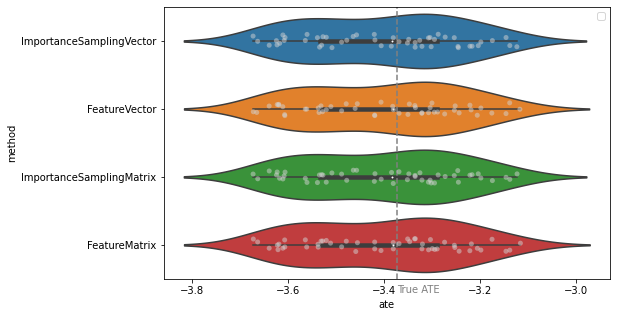

In [9]:
outcome_model = Standardization(make_pipeline(PolynomialFeatures(2), LassoCV(random_state=0)))
weight_model = IPW(LogisticRegression(penalty="none", random_state=0))

pred_ates, true_ates = compare_TMLE_flavors(outcome_model, weight_model, 50, 5000)
plot_tmle_flavor_comparison(pred_ates, true_ates)

We see that all methods are comparable for the relatively simple case at hand.